In [3]:
import torch
import sys
import os
import time
import numpy as np
import argparse
sys.path.append("..")

from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import UmapLoss, ReconstructionLoss, SingleVisLoss
from singleVis.edge_dataset import DataHandler
from singleVis.trainer import SingleVisTrainer
from singleVis.data import NormalDataProvider
from singleVis.spatial_edge_constructor import kcSpatialAlignmentEdgeConstructor
# from singleVis.temporal_edge_constructor import GlobalTemporalEdgeConstructor
from singleVis.alignment_edge_constructor import LocalAlignmentEdgeConstructor
from singleVis.projector import TimeVisProjector
from singleVis.eval.evaluator import Evaluator


import torch
import numpy as np
from CKA import CKA, CudaCKA

# REF_PATH : reference dataset path
# CONFUSION_PATH : benchmark1
# EXCHANGE_PATH : benchmark2

REF_PATH = "/home/yifan/dataset/noisy/pairflip/cifar10/noisy0.001"
CLEAN_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"

CONFUSION_PATH = "/home/yifan/dataset/confusion/pairflip/cifar10/0"
EXCHANGE_PATH = "/home/yifan/dataset/exchange/pairflip/cifar10/0"

sys.path.append(REF_PATH)


from config import config

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
PREPROCESS = VISUALIZATION_PARAMETER["PREPROCESS"]
LAMBDA = VISUALIZATION_PARAMETER["LAMBDA"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
INIT_NUM = VISUALIZATION_PARAMETER["INIT_NUM"]
ALPHA = VISUALIZATION_PARAMETER["ALPHA"]
BETA = VISUALIZATION_PARAMETER["BETA"]
MAX_HAUSDORFF = VISUALIZATION_PARAMETER["MAX_HAUSDORFF"]
# HIDDEN_LAYER = VISUALIZATION_PARAMETER["HIDDEN_LAYER"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
T_N_EPOCHS = VISUALIZATION_PARAMETER["T_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = 'vis'
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

SEGMENTS = [(EPOCH_START, EPOCH_END)]
# define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))


ref_provider = NormalDataProvider(REF_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
clean_provider = NormalDataProvider(CLEAN_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)

confusion_provider = NormalDataProvider(CONFUSION_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)

exchange_provider = NormalDataProvider(EXCHANGE_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)


ref_train_data = ref_provider.train_representation(200).squeeze()

confusion_data = confusion_provider.train_representation(200).squeeze()

exchange_data = exchange_provider.train_representation(200).squeeze()

clean_data = clean_provider.train_representation(200).squeeze()

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Finish initialization...
Finish initialization...
Finish initialization...
Finish initialization...


In [18]:
###  ============================= caculate cca ============================== ###
import numpy as np
from sklearn.cross_decomposition import CCA
exchange_cca_list = []
# 建立模型
# arr = [exchange_provider.train_representation(100),exchange_provider.train_representation(101),exchange_provider.train_representation(102),exchange_provider.train_representation(103),exchange_provider.train_representation(104),exchange_provider.train_representation(105),exchange_provider.train_representation(106),exchange_provider.train_representation(107),exchange_provider.train_representation(108),exchange_provider.train_representation(109),exchange_provider.train_representation(110)]
arr = [exchange_provider.train_representation(197),exchange_provider.train_representation(198),exchange_provider.train_representation(199),exchange_provider.train_representation(196),exchange_provider.train_representation(190),exchange_provider.train_representation(193),exchange_provider.train_representation(194),exchange_provider.train_representation(195),exchange_provider.train_representation(192),exchange_provider.train_representation(191),exchange_provider.train_representation(200)]
for i in range(len(arr)-1):
    X = arr[i]
    Y = arr[i+1]
    # if i == 19:
    #     Y = confusion_provider.train_representation(20)
    # if i == 20:
    #     X = confusion_provider.train_representation(20)

    cca = CCA(n_components=1)
    cca.fit(X, Y)
    X_train_r, Y_train_r = cca.transform(X, Y)

    print(i)
    exchange_cca_list.append(np.corrcoef(X_train_r[:, 0], Y_train_r[:, 0])[0, 1])
    # print(np.corrcoef(X_train_r[:, 0], Y_train_r[:, 0])[0, 1]) #输出相关系数


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


0


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


1


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


2


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


3


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


4


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


5


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


6


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


7


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


8


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


9


In [19]:
print(exchange_cca_list)

[0.9998966418594631, 0.9998929652618687, 0.9999051747817906, 0.9998596103239549, 0.9998588676247356, 0.9999090066827392, 0.9998853423154211, 0.9998335972984438, 0.9999039018896989, 0.9999008713278972]


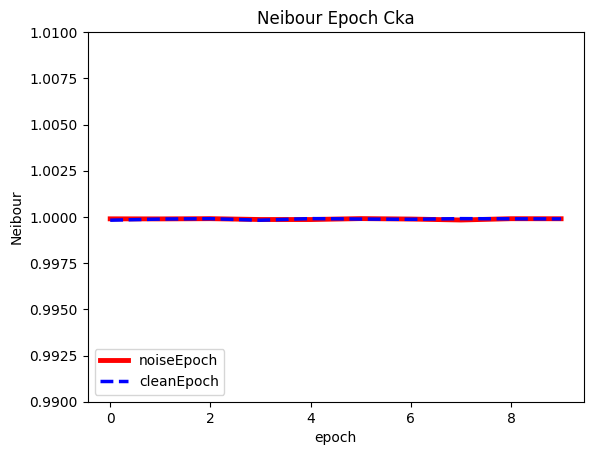

In [28]:
noise_cca_list = [0.9998966418594631, 0.9998929652618687, 0.9999051747817906, 0.9998596103239549, 0.9998588676247356, 0.9999090066827392, 0.9998853423154211, 0.9998335972984438, 0.9999039018896989, 0.9999008713278972]
clean_cca_list =[0.999823400565184, 0.9998840907200951, 0.9999046966817794, 0.999823202886412, 0.9999090066827392, 0.9998853423154211, 0.9998704787689346, 0.9999073108395595, 0.9998966418594631, 0.9998929652618687]
import matplotlib.pyplot as plt

plt.figure()
plt.ylim(0.99,1.01)
plt.xlabel('epoch')
plt.ylabel('Neibour')
plt.title('Neibour Epoch Cka')

# plt.plot([9,10],[noise_cca_list[9],noise_cca_list[10] ],'o', c='red') 

# linestyle="--"
plt.plot(noise_cca_list, 'r', lw=3.5, label='noiseEpoch')
plt.plot(clean_cca_list, 'b', lw=2.5, label='cleanEpoch' ,linestyle="--" )
# plt.plot(confusion_cca_list, 'b', lw=1.5, label='confusion')
plt.legend(loc=3)
plt.show()

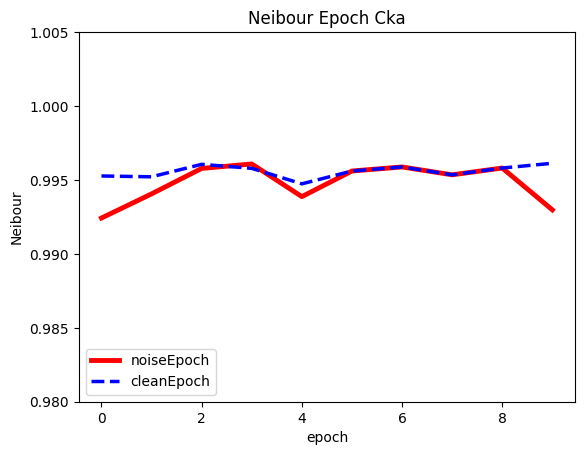

In [31]:
noise_cca_list = [0.9924252236482796, 0.9940577854631271, 0.9957806532463902, 0.9960820272822614, 0.9938723241454623, 0.9956055362180464, 0.9958798016997922, 0.9953485948895525, 0.9958069636084204, 0.992976351543308]
clean_cca_list = [0.9952701465275648, 0.9952135883499701, 0.9960578885732313, 0.9957861189231559, 0.9947373914503317, 0.9956055362180464, 0.9958798016997922, 0.9953485948895525, 0.9958069636084204, 0.9961294848008391]

import matplotlib.pyplot as plt

plt.figure()
plt.ylim(0.98,1.005)
plt.xlabel('epoch')
plt.ylabel('Neibour')
plt.title('Neibour Epoch Cka')

# plt.plot([9,10],[noise_cca_list[9],noise_cca_list[10] ],'o', c='red') 

# linestyle="--"
plt.plot(noise_cca_list, 'r', lw=3.5, label='noiseEpoch')
plt.plot(clean_cca_list, 'b', lw=2.5, label='cleanEpoch' ,linestyle="--" )
# plt.plot(confusion_cca_list, 'b', lw=1.5, label='confusion')
plt.legend(loc=3)
plt.show()

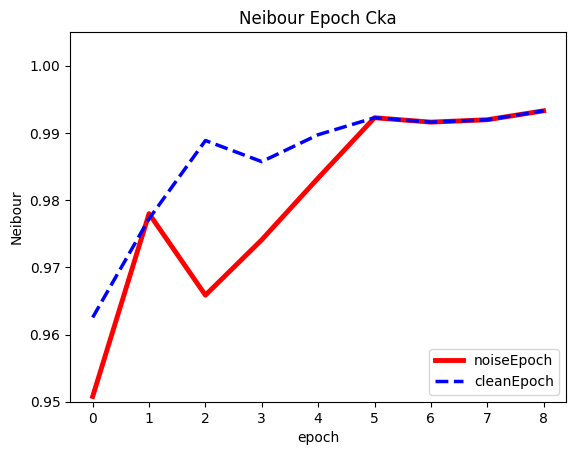

In [36]:
noise_cca_list = [0.9507873771750444, 0.9779898465132508, 0.9658555739870661, 0.9741038301696623, 0.9832848982861507, 0.9922574393105134, 0.9916061426441319, 0.9919612344401878, 0.9932897196417003]
clean_cca_list = [0.9625416922637114, 0.9772292140858627, 0.9888686550353462, 0.9857288543705459, 0.9897333847102339, 0.9922574393105134, 0.9916061426441319, 0.9919612344401878, 0.9932897196417003]

import matplotlib.pyplot as plt

plt.figure()
plt.ylim(0.95,1.005)
plt.xlabel('epoch')
plt.ylabel('Neibour')
plt.title('Neibour Epoch Cka')

# plt.plot([9,10],[noise_cca_list[9],noise_cca_list[10] ],'o', c='red') 

# linestyle="--"
plt.plot(noise_cca_list, 'r', lw=3.5, label='noiseEpoch')
plt.plot(clean_cca_list, 'b', lw=2.5, label='cleanEpoch' ,linestyle="--" )
# plt.plot(confusion_cca_list, 'b', lw=1.5, label='confusion')
plt.legend(loc=4)
plt.show()

In [ ]:
import numpy as np
from sklearn.cross_decomposition import CCA
ccaConList = []
# 建立模型

for i in range(1, 199):
    X = confusion_provider.train_representation(i)
    Y = confusion_provider.train_representation(i+1)
    cca = CCA(n_components=1)
    cca.fit(X, Y)
    X_train_r, Y_train_r = cca.transform(X, Y)
    print(i)
    ccaList.append(np.corrcoef(X_train_r[:, 0], Y_train_r[:, 0])[0, 1])
    print(np.corrcoef(X_train_r[:, 0], Y_train_r[:, 0])[0, 1]) #输出相关系数